# \[04\] Aggregate Data

## Some Thoughts about what to aggregate

We want to make predictions for a user, whether he is likely to churn in the near future or not based on the histoy data we have.  
This means, that our data has to be aggregated per user.

We have roughly 2 Months of data for training. 
So, we can make an split after 6 weeks. Then we have 6 weeks of history data and 2 weeks in the future to find out, which users churned.

So, our label is 1, if a users churns in the last two weeks of our event log.
For training we use all other data, except the last two weeks.

But it might be neccessary to modify this "split". Perhaps it makes sense, to look only one week into the future instead of two, or to use only the history data of the last three weeks instead of 6.  
So, instead of aggregating all the data, we will make aggregations per user per week.
So we are flexible afterwards what to use for training.

One week is a good unit for aggregation, because it balances changes between the working days and the weekend.



## Setup Spark Session

for a detailed description what is done here see [01-setup-spark-session.ipynb](01-setup-spark-session.ipynb)


In [32]:
# EVENT_DATA_URL = "s3a://udacity/sparkify/sparkify_event_data.json"
EVENT_DATA_URL = "s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

CLEAN_DATA_URL = EVENT_DATA_URL.replace("/sparkify/", "/sparkify/output/02-cleaned-")
WEEK_AGGREGATED_DATA_URL = EVENT_DATA_URL.replace("/sparkify/", "/sparkify/output/04-week-aggregated-")

EXECUTOR_INSTANCES = 2
EXECUTOR_MEM = '6g'

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from cryptography.fernet import Fernet
import base64
import socket

!./install-s3-jars.sh

def decrypt(encrypted_text):
    """
    decrypts an encrypted text. The seed (master-password) for decryption is read from the file ".seed.txt"
    
    Input: encrypted_text
    
    Output: the decrypted text. If the text was not encrypted with the same seed, 
            an exception is raised.
    """
    with open('.seed.txt') as f:
        seed = f.read().strip()
    return Fernet(base64.b64encode((seed*32)[:32].encode('ascii')).decode('ascii')).decrypt(encrypted_text.encode('ascii')).decode('ascii')

AWS_ACCESS_KEY_ID='V6ge1JcQpvyYGJjb'
AWS_SECRET_ACCESS_KEY = decrypt('gAAAAABkDFI6865LaVJVgtTYo0aMx9-JTPbTo6cwOUjg5eNNPsZhBDoHbRZ8xuXQT0ImNfvqcecZuoJd1VzYQEpBaxyCnKvosii8O1KeqoL2NwKdKtL_AUfT4eW4dvJVP--VjEvc0gB4')
OWN_IP=socket.gethostbyname(socket.gethostname())
APP_NAME = "Sparkify"
SPARK_MASTER = "spark://bit-spark-master-svc.spark.svc.cluster.local:7077"
S3_HOST = "minio-api-service.minio.svc"

print(f'### SETUP SPARK SESSION "{APP_NAME}"')
spark = SparkSession.builder \
    .master(SPARK_MASTER) \
    .config("spark.jars","/home/jovyan/jars/aws-java-sdk-bundle-1.11.1026.jar,/home/jovyan/jars/hadoop-aws-3.3.2.jar") \
    .config("spark.driver.host", OWN_IP) \
    .config("spark.hadoop.fs.s3a.endpoint", S3_HOST) \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.access.key", AWS_ACCESS_KEY_ID) \
    .config("spark.hadoop.fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY) \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.executor.instances", EXECUTOR_INSTANCES) \
    .config("spark.executor.memory", EXECUTOR_MEM) \
    .appName(APP_NAME).getOrCreate()
print(f"Spark version: {spark.version}")
sc = spark.sparkContext
sc.setLogLevel("WARN")



### SETUP SPARK SESSION "Sparkify"
Spark version: 3.3.2


## Get Clean Data

There are two possibilities, how to get the cleaned data.  
Load the saved data saved in step 02 from S3 or reapply the transformations to the original dataset.  

**Only apply one of both possibilities**

### Possibility 1 - Load cleaned dataset

In [2]:
print(f"### LOAD DATA {CLEAN_DATA_URL}")
df = spark.read.json(CLEAN_DATA_URL)
print(f"### PERSIST")
df_persist = df.persist()
df = df_persist

### LOAD DATA s3a://udacity-dsnd/sparkify/output/02-cleaned-mini_sparkify_event_data.json
### PERSIST


### Possibility 2 - Load original dataset and Apply Transformations

For a detailed description what is done here see [02-data-introspection.ipynb](02-data-introspection.ipynb)

In [33]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

print(f"### LOAD DATA {EVENT_DATA_URL}")
df = spark.read.json(EVENT_DATA_URL)

def norm_colname(name):
    """
    Input: name which can contain spaces with upper and lowercase letters.
    Output: all spaces replaced with an underscore and all letters converted to lowercase
    """
    return name.replace(' ', '_').lower()

print(f"### DROP UNUSED COLUMNS")
df = df.drop("artist", "auth", "firstName", "lastName", "length", "location", "method", "song", "userAgent")
print(f"### REMOVE EMPTY USERID")
df = df.filter(df.userId != '')
print(f"### ADD ID")
w = Window().orderBy("ts")
df = df.withColumn("id", F.row_number().over(w))
print(f"### VECTORIZE PAGE FEATURES")
page_features = df.groupBy("id").pivot("page").agg(F.lit(1)).na.fill(0)
page_features = page_features.toDF(*(("pg_"+norm_colname(col)) if col!="id" else "id" for col in page_features.columns))
df = df.join(page_features, "id")
print(f"### VECTORIZE LEVEL FEATURE")
df = df.withColumn("paid", (df.level == 'paid').cast('int'))
df = df.drop("level")
print(f"### VECTORIZE GENDER FEATURE")
df = df.withColumn("male", (df.gender == 'M').cast('int'))
df = df.drop("gender")
print(f"### VECTORIZE STATUS FEATURES")
status_features = df.groupBy("id").pivot("status").agg(F.lit(1)).na.fill(0)
status_features = status_features.toDF(*(("status_"+col) if col != "id" else "id" for col in status_features.columns)).drop("status_200")
df = df.join(status_features, "id")
df = df.drop("status")
print(f"### ADD SID")
df_sess_user = df.select("sessionId", "userId").dropDuplicates()
w = Window().orderBy("sessionId", "userId")
df_sess_user = df_sess_user.withColumn("sid", F.row_number().over(w))
df = df.join(df_sess_user, ["sessionId", "userId"])
df_session_start = df.groupBy("sid").agg(F.min("id").alias("id")).drop("sid").withColumn("session_start", F.lit(1).cast("int"))
df = df.join(df_session_start, "id", how="outer").fillna(0)
df = df.drop("sessionId", "itemInSession")
print(f"### PERSIST")
df_persist = df.persist()
df = df_persist

### LOAD DATA s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json
### DROP UNUSED COLUMNS
### REMOVE EMPTY USERID
### ADD ID
### VECTORIZE PAGE FEATURES
### VECTORIZE LEVEL FEATURE
### VECTORIZE GENDER FEATURE
### VECTORIZE STATUS FEATURES
### ADD SID
### PERSIST


## Imports

Here are all imports which are needed in the cells below.

In [34]:
import pyspark.sql.functions as F
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime


## Constants

constants that are used in the cells below

In [35]:
# timestamp constants for ts in milliseconds
one_hour =        60*60*1000  #     3.600.000
one_day =      24*60*60*1000  #    86.400.000
one_week =   7*24*60*60*1000  #   604.800.000
one_month = 28*24*60*60*1000  # 2.419.200.000

## Decide what and how to aggregate

Let´s take a look at the columns

In [36]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- pg_about: integer (nullable = true)
 |-- pg_add_friend: integer (nullable = true)
 |-- pg_add_to_playlist: integer (nullable = true)
 |-- pg_cancel: integer (nullable = true)
 |-- pg_cancellation_confirmation: integer (nullable = true)
 |-- pg_downgrade: integer (nullable = true)
 |-- pg_error: integer (nullable = true)
 |-- pg_help: integer (nullable = true)
 |-- pg_home: integer (nullable = true)
 |-- pg_logout: integer (nullable = true)
 |-- pg_nextsong: integer (nullable = true)
 |-- pg_roll_advert: integer (nullable = true)
 |-- pg_save_settings: integer (nullable = true)
 |-- pg_settings: integer (nullable = true)
 |-- pg_submit_downgrade: integer (nullable = true)
 |-- pg_submit_upgrade: integer (nullable = true)
 |-- pg_thumbs_down: integer (nullable = true)
 |-- pg_thumbs_up: integer (nu

## New Column Week-ID "wid"

We will tag each row with a week-id.

We can derive the week from the timestamp column "ts".  
One simple tagging would be to use the value of "ts" divided by the milliseconds of one week.  
But then we will get a fraction of a week at the end of our data (the label section).  
So, we will use the latest timestamp `ts` (=`ts_last`) from our dataset as a reference and calculate all timestamps as how far in the past from this timestamp `ts_last` they are.

As a consequence the oldest aggregated week will not be complete, it may be dropped from training if this causes issues.



In [37]:
ts_first = df.agg(F.min(df.ts).alias("ts_first")).collect()[0].ts_first
ts_last = df.agg(F.max(df.ts).alias("ts_last")).collect()[0].ts_last
days = (ts_last - ts_first)/one_day
print(f"first timestamp: {datetime.datetime.fromtimestamp(ts_first/1000.0)}")
print(f"last timestamp: {datetime.datetime.fromtimestamp(ts_last/1000.0)}")
print(f"days: {days}")


first timestamp: 2018-10-01 00:01:57
last timestamp: 2018-12-03 01:11:16
days: 63.04813657407407


### Event Distribution

Lets take a look at the distribution per day:

In [38]:
df = df.withColumn("past", (ts_last-F.col("ts"))/one_day)

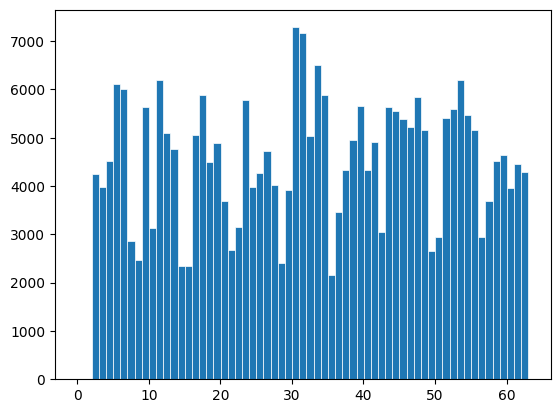

In [39]:
x = [row.past for row in df.select("past").collect()]
plt.hist(x, bins=round(days), linewidth=0.5, edgecolor="white")
plt.show()

That is really strange. The events do not start at 0.
Lets zoom into the last week:

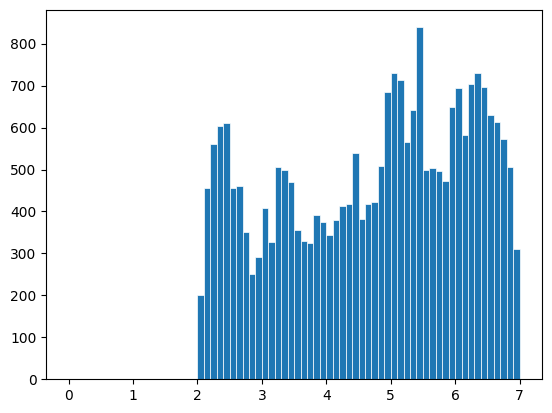

In [40]:
x = [row.past for row in df.where(F.col("past")<7).select("past").collect()]
plt.hist(x, bins=70, linewidth=0.5, edgecolor="white")
plt.show()

There must be some outlyer, so that the last timestamp is 2 days ahead of all others

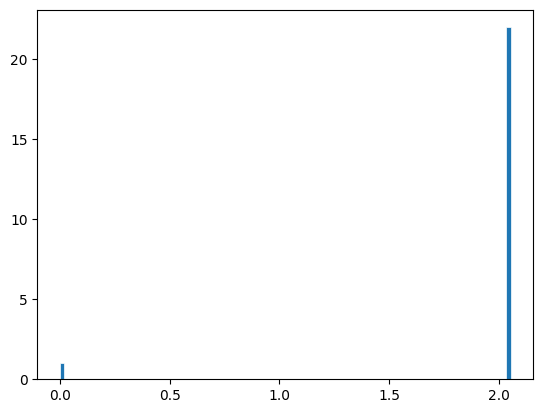

In [41]:
x = [row.past for row in df.where(F.col("past")<2.055).select("past").collect()]
plt.hist(x, bins=100, linewidth=0.5, edgecolor="white")
plt.show()

Somehow there is one timestamp ahead of all others.
We will directly remove it

In [42]:
df = df.where(F.col("ts")!=ts_last)

Now we have to recalculate the timestamps

In [43]:
ts_first = df.agg(F.min(df.ts).alias("ts_first")).collect()[0].ts_first
ts_last = df.agg(F.max(df.ts).alias("ts_last")).collect()[0].ts_last
days = (ts_last - ts_first)/one_day
print(f"first timestamp: {datetime.datetime.fromtimestamp(ts_first/1000.0)}")
print(f"last timestamp: {datetime.datetime.fromtimestamp(ts_last/1000.0)}")
print(f"days: {days}")


first timestamp: 2018-10-01 00:01:57
last timestamp: 2018-12-01 00:02:59
days: 61.00071759259259


In [44]:
df = df.withColumn("past", (ts_last-F.col("ts"))/one_day)

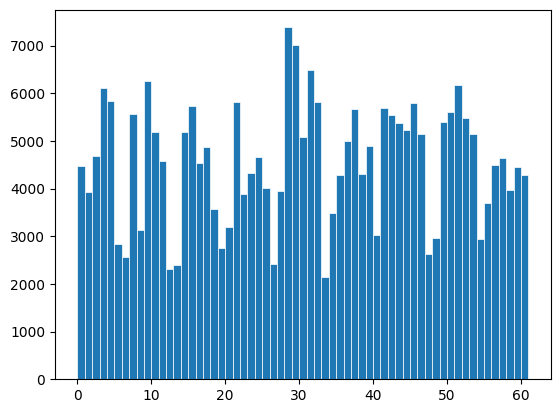

In [45]:
x = [row.past for row in df.select("past").collect()]
plt.hist(x, bins=round(days), linewidth=0.5, edgecolor="white")
plt.show()

Now it looks much better.  
We can see a 7-day cycle. It shows, that there are more events during workdays than at the weekend.  
To be sure, lets again zoom into the last week (0-6)

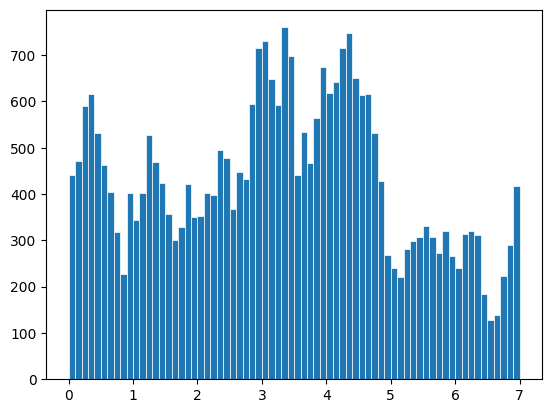

In [46]:
x = [row.past for row in df.where(F.col("past")<7).select("past").collect()]
plt.hist(x, bins=70, linewidth=0.5, edgecolor="white")
plt.show()

Now we can define our Week-Identifier

In [47]:
df = df.withColumn("wid", F.floor((ts_last-F.col("ts"))/one_week))
df.groupBy("wid").count().sort("wid").show()

+---+-----+
|wid|count|
+---+-----+
|  0|30425|
|  1|29436|
|  2|29875|
|  3|29088|
|  4|37440|
|  5|32872|
|  6|32715|
|  7|34449|
|  8|21853|
+---+-----+



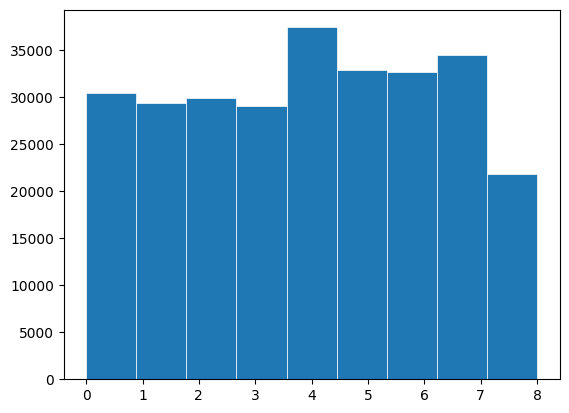

In [48]:
x = [row.wid for row in df.select("wid").collect()]
plt.hist(x, bins=9, linewidth=0.5, edgecolor="white")
plt.show()

Distribution of Week-ID now looks also fine. The last week (8) is filled only 2/3. That are the two days missing (61 modulo 7 is 5).

### Constant User data

The columns"male" and "registration" are constant for a user.
Let´s check this:

In [49]:
df.groupBy("userId").agg(F.min(F.col("male")).alias("male_min"), F.max(F.col("male")).alias("male_max")).where(F.col("male_min") != F.col("male_max")).count()

0

In [50]:
df.groupBy("userId").agg(F.min(F.col("registration")).alias("registration_min"), F.max(F.col("registration")).alias("registration_max")).where(F.col("registration_min") != F.col("registration_max")).count()

0

We will collect user-constant values in a seperate dataframe and rename it to "user_male" and "user_registrationdays".
For these columns no aggregation is needed.  
Instead of the absolute registration timestamp, we will calculate how many days before `ts_last`it was.

In [51]:
df_user = df.groupBy("userId").agg(F.max(F.col("male")).alias("usermale"), F.max((ts_last-F.col("registration"))/one_day).alias("userregistration"))
df_user.show(5)

+------+--------+------------------+
|userId|usermale|  userregistration|
+------+--------+------------------+
|100010|       0| 64.88702546296297|
|200002|       1| 85.10038194444445|
|    51|       1| 64.13879629629629|
|   124|       0|131.92412037037036|
|    54|       0|128.93422453703704|
+------+--------+------------------+
only showing top 5 rows



## Irrelevant Columns

The columns "id" and "page" are not relevant for training and can be dropped in the aggregated data

## Page, Status Events and Session Starts

all "pg_..." and "status_..." columns can be aggregated by building the sum.  
So, we can see, how often a user clicked a button/hit a 404 page/... in the aggregated time (week)

In [52]:
sum_cols = [col for col in df.columns if col.startswith("pg_") or col.startswith("status_")]
aggs = [F.sum(F.col(col)).alias(col) for col in sum_cols]
df_pg_status_agg = df.groupBy("userId", "wid").agg(*aggs)
df_pg_status_agg.show(1, vertical=True)

-RECORD 0---------------------------
 userId                       | 87  
 wid                          | 5   
 pg_about                     | 1   
 pg_add_friend                | 0   
 pg_add_to_playlist           | 2   
 pg_cancel                    | 1   
 pg_cancellation_confirmation | 1   
 pg_downgrade                 | 1   
 pg_error                     | 0   
 pg_help                      | 0   
 pg_home                      | 6   
 pg_logout                    | 3   
 pg_nextsong                  | 145 
 pg_roll_advert               | 0   
 pg_save_settings             | 0   
 pg_settings                  | 1   
 pg_submit_downgrade          | 0   
 pg_submit_upgrade            | 1   
 pg_thumbs_down               | 1   
 pg_thumbs_up                 | 3   
 pg_upgrade                   | 1   
 status_307                   | 9   
 status_404                   | 0   
only showing top 1 row



## Timestamps and Sessions

We have marked the first timestamp in every session with session_start=1. So summing up `session_start` will show us, how many sessions a user had during the aggregation interval.  
If a session overlaps to the next week then the session start will only ne counted for the first week.

The temporary column "max_id" contains the maximum value of column "id" and is used to have a reference to the last event logged in this interval.  
This will be used later for the column paid.


In [53]:
aggs = [F.sum(F.col("session_start")).alias("session_start"), F.max(F.col("id")).alias("max_id")]
df_sessionstart_agg = df.groupBy("userId", "wid").agg(*aggs)
df_sessionstart_agg.show(5)

+------+---+-------------+------+
|userId|wid|session_start|max_id|
+------+---+-------------+------+
|    87|  5|            1| 92809|
|    71|  5|            2|119326|
|    63|  4|            1|141789|
|    60|  2|            4|218292|
|    35|  7|            5| 56295|
+------+---+-------------+------+
only showing top 5 rows



Next to the number of sessions, it might be interesting, how much time a user spend all together in Sparkify.  
This can be calculated by grouping additional by "sid" (the session id) and building min() and max() from "ts".  
The sum of all difference "max(ts)-min(ts)" is then the time the user has used Sparkify in this week.  
To find a better scaling the value is scaled from milliseconds into hours.

In [54]:
df_sessionhours_agg = df.groupBy("userId", "wid", "sid").agg(F.max(F.col("ts")), F.min(F.col("ts"))).withColumn("session_hours", (F.col("max(ts)")-F.col("min(ts)"))/one_hour).groupBy("userId", "wid").agg(F.sum(F.col("session_hours")).alias("session_hours"))
df_sessionhours_agg.show(5)

+------+---+------------------+
|userId|wid|     session_hours|
+------+---+------------------+
|    71|  5|13.503611111111113|
|200011|  7|20.758333333333333|
|    60|  2| 37.21527777777778|
|    37|  2| 19.60472222222222|
|    35|  7| 26.32111111111111|
+------+---+------------------+
only showing top 5 rows



## Column "paid"

For the paid status it might be interesting to know the current state, because downgrading is only possible, if the current state is "paid".  
It is not of interest, how many events were issued, while the state was paid. So, summing up would be of no value.  
Instead of, we should take the last state in the aggregation time. We can use the already aggregated column past_end for finding the latest status.  

In [55]:
df_paid_agg = df.join(df_sessionstart_agg.withColumnRenamed("max_id", "id"), ["userId", "wid", "id"]).select("userId", "wid", "id", "paid").drop("id")
df_sessionstart_agg = df_sessionstart_agg.drop("max_id")
df_paid_agg.groupBy("paid").count().show()

+----+-----+
|paid|count|
+----+-----+
|   1|  766|
|   0|  526|
+----+-----+



## Putting it all together

Now, where we have all the pieces, we can put them together to have one dataset as base for generating training data.  
To simplify things, we will add the user constant values to each week, so we do not have to maintain two datasets.  
The amount of data duplicatio is not so high.  

In [56]:
df_userweek = df_pg_status_agg.join(df_sessionstart_agg, ["userId", "wid"])
df_userweek = df_userweek.join(df_sessionhours_agg, ["userId", "wid"])
df_userweek = df_userweek.join(df_paid_agg, ["userId", "wid"])
df_userweek = df_userweek.join(df_user, ["userId"])


In [57]:
df_userweek.show(1, vertical=True)

-RECORD 0------------------------------------------
 userId                       | 87                 
 wid                          | 5                  
 pg_about                     | 1                  
 pg_add_friend                | 0                  
 pg_add_to_playlist           | 2                  
 pg_cancel                    | 1                  
 pg_cancellation_confirmation | 1                  
 pg_downgrade                 | 1                  
 pg_error                     | 0                  
 pg_help                      | 0                  
 pg_home                      | 6                  
 pg_logout                    | 3                  
 pg_nextsong                  | 145                
 pg_roll_advert               | 0                  
 pg_save_settings             | 0                  
 pg_settings                  | 1                  
 pg_submit_downgrade          | 0                  
 pg_submit_upgrade            | 1                  
 pg_thumbs_d

## Save to S3

The aggregated data per week can be saved to a S3 bucket for reusing it when generating different sets of training data.

In [ ]:
WEEK_AGGREGATED_DATA_URL = EVENT_DATA_URL.replace("/sparkify/", "/sparkify/output/04-week-aggregated-")

print(f"### SAVING CLEANED DATA {WEEK_AGGREGATED_DATA_URL}")
df.write.format('json').mode('overwrite').save(WEEK_AGGREGATED_DATA_URL)
print(f"finished")

In [27]:
spark.stop()